# 라이브러리 임포트

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd

from models.VAE import VariationalAutoencoder
from utils.loaders import load_model, ImageLabelLoader

In [4]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])

DATA_FOLDER = './data/celeb/'
IMAGE_FOLDER = './data/celeb/img_align_celeba/'

JC_IMAGE_FOLDER = './data/celeb/input_image/'

# 데이터 적재

In [5]:
INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))
JC_csv = pd.read_csv(os.path.join(DATA_FOLDER, 'input.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])
JC_imageLoader = ImageLabelLoader(JC_IMAGE_FOLDER, INPUT_DIM[:2])

# 모델만들기

In [6]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

In [7]:
n_to_show=10
data_flow_generic = imageLoader.build(att, n_to_show)
JC_data_flow_generic = JC_imageLoader.build(JC_csv, n_to_show)

Found 202599 validated image filenames.
Found 3 validated image filenames.


# 새로 생성한 얼굴

In [8]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)
   
    origin = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
       
        im = batch[0]
     
        attribute = batch[1]
    
        z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]   
        z_NEG = z[attribute==-1]
    
        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist
        
        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector

In [9]:
def add_vector_to_images(feature_vec):

    n_to_show = 3
    factors = [-4,-3,-2,-1,0,1,2,3,4]
    
    JC_example_batch = next(JC_data_flow_generic)
    JC_example_images = JC_example_batch[0]
    JC_example_labels = JC_example_batch[1]

    JC_z_points = vae.encoder.predict(JC_example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = JC_example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = JC_z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1
    
    plt.show()

In [10]:
BATCH_SIZE = 500
male_vec = get_vector_from_label('Male', BATCH_SIZE)
black_hair_vec= get_vector_from_label('Black_Hair', BATCH_SIZE)
blonde_hair_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)
brown_hair_vec= get_vector_from_label('Brown_Hair', BATCH_SIZE)
gray_hair_vec= get_vector_from_label('Gray_Hair', BATCH_SIZE)
straight_hair_vec= get_vector_from_label('Straight_Hair', BATCH_SIZE)
wavy_hair_vec= get_vector_from_label('Wavy_Hair', BATCH_SIZE)
heavy_makeup_vec= get_vector_from_label('Heavy_Makeup', BATCH_SIZE)
mustache_vec= get_vector_from_label('Mustache', BATCH_SIZE)
wearing_hat_vec= get_vector_from_label('Wearing_Hat', BATCH_SIZE)
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)

#print(example_batch)
#print(JC_example_batch)

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Male
images : POS move : NEG move :distance : 𝛥 distance
212    : 1.292    : 0.944    : 1.801    : 1.801
428    : 0.716    : 0.616    : 1.565    : -0.236
633    : 0.382    : 0.306    : 1.447    : -0.118
844    : 0.278    : 0.232    : 1.371    : -0.076
1048    : 0.21    : 0.191    : 1.36    : -0.011
1253    : 0.183    : 0.151    : 1.354    : -0.006
1460    : 0.159    : 0.127    : 1.342    : -0.012
1657    : 0.122    : 0.11    : 1.336    : -0.006
1871    : 0.111    : 0.097    : 1.329    : -0.007
2067    : 0.105    : 0.084    : 1.326    : -0.004
2268    : 0.093    : 0.073    : 1.309    : -0.016
2490    : 0.094    : 0.075    : 1.297    : -0.013
2704    : 0.081    : 0.061    : 1.286    : -0.011
2908    : 0.078    : 0.059    : 1.275    : -0.011
3108    : 0.067    : 0.053    : 1.274    : -0.001
3321    : 0.061    : 0.049    : 1.273    : -0.001
3526    : 0.061    : 0.051    : 1.274    : 0.0
3727    : 0.058    : 0.048    : 1.266    : -0.008
3921   

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Black_Hair
images : POS move : NEG move :distance : 𝛥 distance
118    : 1.563    : 0.831    : 1.891    : 1.891
236    : 0.992    : 0.482    : 1.527    : -0.364
358    : 0.575    : 0.303    : 1.374    : -0.153
457    : 0.339    : 0.208    : 1.285    : -0.089
579    : 0.319    : 0.159    : 1.243    : -0.042
700    : 0.265    : 0.119    : 1.196    : -0.047
830    : 0.19    : 0.111    : 1.152    : -0.044
941    : 0.164    : 0.105    : 1.131    : -0.021
1069    : 0.16    : 0.08    : 1.116    : -0.015
1191    : 0.14    : 0.069    : 1.122    : 0.006
1306    : 0.118    : 0.068    : 1.123    : 0.0
1415    : 0.114    : 0.055    : 1.115    : -0.008
1543    : 0.103    : 0.052    : 1.112    : -0.003
1664    : 0.101    : 0.053    : 1.102    : -0.01
1787    : 0.095    : 0.051    : 1.1    : -0.002
1888    : 0.081    : 0.047    : 1.092    : -0.008
2014    : 0.08    : 0.045    : 1.085    : -0.007
2133    : 0.073    : 0.041    : 1.079    : -0.006
2245    : 0

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
81    : 1.99    : 0.649    : 2.215    : 2.215
156    : 1.064    : 0.433    : 1.865    : -0.35
235    : 0.609    : 0.266    : 1.696    : -0.169
301    : 0.445    : 0.215    : 1.641    : -0.055
382    : 0.36    : 0.147    : 1.625    : -0.015
469    : 0.329    : 0.119    : 1.594    : -0.031
547    : 0.225    : 0.107    : 1.565    : -0.029
624    : 0.197    : 0.092    : 1.563    : -0.002
685    : 0.156    : 0.082    : 1.54    : -0.023
752    : 0.157    : 0.076    : 1.547    : 0.007
812    : 0.14    : 0.064    : 1.528    : -0.019
882    : 0.131    : 0.057    : 1.52    : -0.008
957    : 0.121    : 0.053    : 1.519    : -0.0
1036    : 0.123    : 0.052    : 1.509    : -0.011
1116    : 0.12    : 0.045    : 1.497    : -0.011
1197    : 0.108    : 0.046    : 1.484    : -0.013
1267    : 0.1    : 0.042    : 1.485    : 0.0
1346    : 0.093    : 0.04    : 1.488    : 0.003
1417    : 0.08    : 0.

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Brown_Hair
images : POS move : NEG move :distance : 𝛥 distance
114    : 1.459    : 0.713    : 1.656    : 1.656
225    : 0.821    : 0.508    : 1.295    : -0.36
311    : 0.504    : 0.317    : 1.12    : -0.175
406    : 0.369    : 0.207    : 1.025    : -0.095
504    : 0.288    : 0.169    : 0.951    : -0.074
596    : 0.251    : 0.132    : 0.905    : -0.046
706    : 0.23    : 0.108    : 0.869    : -0.035
814    : 0.191    : 0.087    : 0.855    : -0.014
923    : 0.151    : 0.078    : 0.825    : -0.03
1032    : 0.146    : 0.072    : 0.802    : -0.022
1146    : 0.139    : 0.07    : 0.775    : -0.027
1258    : 0.128    : 0.067    : 0.753    : -0.023
1346    : 0.096    : 0.059    : 0.732    : -0.021
1458    : 0.105    : 0.053    : 0.726    : -0.006
1552    : 0.086    : 0.05    : 0.725    : -0.001
1655    : 0.085    : 0.042    : 0.722    : -0.003
1757    : 0.082    : 0.041    : 0.722    : 0.0
1862    : 0.084    : 0.038    : 0.716    : -0.007
1963    :

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Gray_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 3.182    : 0.613    : 3.261    : 3.261
40    : 1.851    : 0.462    : 2.678    : -0.583
56    : 1.187    : 0.275    : 2.441    : -0.237
77    : 0.932    : 0.184    : 2.309    : -0.132
100    : 0.837    : 0.15    : 2.142    : -0.168
127    : 0.645    : 0.117    : 2.049    : -0.093
149    : 0.465    : 0.094    : 1.964    : -0.085
169    : 0.388    : 0.083    : 1.927    : -0.037
186    : 0.33    : 0.074    : 1.935    : 0.008
216    : 0.347    : 0.068    : 1.915    : -0.019
235    : 0.284    : 0.059    : 1.894    : -0.021
255    : 0.24    : 0.057    : 1.876    : -0.018
271    : 0.229    : 0.053    : 1.89    : 0.014
291    : 0.22    : 0.047    : 1.876    : -0.014
311    : 0.206    : 0.046    : 1.827    : -0.049
332    : 0.198    : 0.04    : 1.836    : 0.009
349    : 0.163    : 0.038    : 1.825    : -0.011
372    : 0.177    : 0.036    : 1.816    : -0.009
396    : 0.187    : 0.0

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Straight_Hair
images : POS move : NEG move :distance : 𝛥 distance
110    : 1.379    : 0.772    : 1.556    : 1.556
237    : 1.013    : 0.475    : 1.164    : -0.392
343    : 0.528    : 0.3    : 0.94    : -0.224
459    : 0.388    : 0.233    : 0.798    : -0.142
566    : 0.313    : 0.149    : 0.78    : -0.018
649    : 0.206    : 0.125    : 0.718    : -0.062
759    : 0.203    : 0.105    : 0.684    : -0.034
867    : 0.194    : 0.099    : 0.655    : -0.029
975    : 0.157    : 0.082    : 0.668    : 0.014
1068    : 0.121    : 0.072    : 0.661    : -0.008
1175    : 0.126    : 0.071    : 0.639    : -0.022
1259    : 0.105    : 0.063    : 0.631    : -0.008
1377    : 0.122    : 0.055    : 0.627    : -0.003
1475    : 0.087    : 0.053    : 0.611    : -0.016
1588    : 0.099    : 0.05    : 0.62    : 0.009
1688    : 0.085    : 0.044    : 0.608    : -0.012
1784    : 0.081    : 0.044    : 0.594    : -0.015
1902    : 0.089    : 0.038    : 0.591    : -0.003
2013 

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Wavy_Hair
images : POS move : NEG move :distance : 𝛥 distance
154    : 1.276    : 0.778    : 1.53    : 1.53
323    : 0.822    : 0.563    : 1.208    : -0.323
505    : 0.495    : 0.273    : 1.083    : -0.125
656    : 0.291    : 0.228    : 1.059    : -0.024
832    : 0.26    : 0.156    : 1.011    : -0.048
1004    : 0.192    : 0.132    : 0.977    : -0.034
1149    : 0.163    : 0.127    : 0.97    : -0.007
1323    : 0.158    : 0.103    : 0.964    : -0.006
1492    : 0.138    : 0.087    : 0.94    : -0.024
1639    : 0.095    : 0.086    : 0.935    : -0.004
1794    : 0.101    : 0.088    : 0.931    : -0.005
1964    : 0.103    : 0.065    : 0.927    : -0.003
2120    : 0.087    : 0.067    : 0.927    : 0.0
2281    : 0.077    : 0.06    : 0.915    : -0.012
2464    : 0.075    : 0.047    : 0.918    : 0.003
2649    : 0.07    : 0.049    : 0.916    : -0.002
2821    : 0.067    : 0.047    : 0.908    : -0.008
2968    : 0.06    : 0.041    : 0.916    : 0.008
3115    : 

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Heavy_Makeup
images : POS move : NEG move :distance : 𝛥 distance
200    : 1.291    : 0.811    : 1.617    : 1.617
389    : 0.714    : 0.593    : 1.413    : -0.204
581    : 0.42    : 0.32    : 1.322    : -0.092
768    : 0.276    : 0.249    : 1.277    : -0.045
971    : 0.234    : 0.165    : 1.237    : -0.04
1160    : 0.189    : 0.155    : 1.2    : -0.037
1354    : 0.161    : 0.122    : 1.169    : -0.031
1537    : 0.13    : 0.102    : 1.161    : -0.008
1752    : 0.113    : 0.088    : 1.16    : -0.001
1947    : 0.115    : 0.084    : 1.17    : 0.009
2147    : 0.091    : 0.087    : 1.163    : -0.007
2351    : 0.08    : 0.07    : 1.157    : -0.006
2540    : 0.078    : 0.066    : 1.151    : -0.006
2726    : 0.067    : 0.063    : 1.135    : -0.017
2918    : 0.07    : 0.057    : 1.137    : 0.002
3105    : 0.057    : 0.054    : 1.14    : 0.003
3296    : 0.06    : 0.05    : 1.137    : -0.003
3487    : 0.055    : 0.042    : 1.139    : 0.002
3682    : 0.

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Mustache
images : POS move : NEG move :distance : 𝛥 distance
21    : 3.411    : 0.623    : 3.513    : 3.513
45    : 2.237    : 0.454    : 2.501    : -1.012
74    : 1.324    : 0.276    : 1.999    : -0.502
97    : 0.824    : 0.182    : 1.804    : -0.195
116    : 0.54    : 0.14    : 1.689    : -0.115
135    : 0.52    : 0.121    : 1.614    : -0.075
155    : 0.409    : 0.097    : 1.604    : -0.01
170    : 0.349    : 0.083    : 1.548    : -0.056
193    : 0.37    : 0.071    : 1.507    : -0.041
222    : 0.348    : 0.071    : 1.475    : -0.032
239    : 0.253    : 0.056    : 1.46    : -0.015
253    : 0.214    : 0.057    : 1.433    : -0.027
278    : 0.258    : 0.052    : 1.435    : 0.003
299    : 0.211    : 0.051    : 1.43    : -0.005
323    : 0.22    : 0.048    : 1.416    : -0.014
352    : 0.238    : 0.043    : 1.387    : -0.029
379    : 0.188    : 0.038    : 1.382    : -0.004
397    : 0.153    : 0.034    : 1.363    : -0.02
414    : 0.139    : 0.036

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Wearing_Hat
images : POS move : NEG move :distance : 𝛥 distance
30    : 2.99    : 0.696    : 3.154    : 3.154
52    : 1.845    : 0.503    : 2.494    : -0.66
71    : 1.042    : 0.269    : 2.16    : -0.334
92    : 0.758    : 0.192    : 2.106    : -0.054
117    : 0.665    : 0.136    : 1.982    : -0.124
138    : 0.484    : 0.124    : 2.015    : 0.033
153    : 0.419    : 0.102    : 2.001    : -0.014
180    : 0.452    : 0.08    : 1.956    : -0.045
202    : 0.339    : 0.071    : 1.947    : -0.009
216    : 0.24    : 0.068    : 1.938    : -0.009
237    : 0.292    : 0.059    : 1.907    : -0.032
268    : 0.314    : 0.051    : 1.905    : -0.002
295    : 0.261    : 0.05    : 1.902    : -0.003
317    : 0.232    : 0.045    : 1.903    : 0.001
341    : 0.216    : 0.044    : 1.873    : -0.03
368    : 0.197    : 0.04    : 1.849    : -0.024
388    : 0.187    : 0.041    : 1.858    : 0.009
411    : 0.166    : 0.038    : 1.848    : -0.011
437    : 0.198    : 0.0

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\samsung\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsung\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsung\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsung\anaconda3\lib\site-packages\tr

Found 202599 validated image filenames.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
29    : 3.032    : 0.63    : 3.158    : 3.158
68    : 2.056    : 0.445    : 2.414    : -0.744
96    : 0.979    : 0.24    : 2.143    : -0.27
129    : 0.699    : 0.18    : 2.085    : -0.059
157    : 0.511    : 0.141    : 1.978    : -0.107
191    : 0.447    : 0.114    : 1.873    : -0.105
220    : 0.358    : 0.108    : 1.79    : -0.082
255    : 0.352    : 0.091    : 1.697    : -0.093
287    : 0.283    : 0.076    : 1.677    : -0.021
324    : 0.288    : 0.062    : 1.613    : -0.063
364    : 0.27    : 0.059    : 1.578    : -0.035
401    : 0.244    : 0.057    : 1.554    : -0.024
429    : 0.176    : 0.051    : 1.542    : -0.012
461    : 0.198    : 0.045    : 1.547    : 0.005
494    : 0.165    : 0.044    : 1.554    : 0.007
528    : 0.152    : 0.042    : 1.564    : 0.009
557    : 0.129    : 0.041    : 1.569    : 0.006
595    : 0.159    : 0.034    : 1.585    : 0.016
626    : 0.124    : 0.0

Male Vector


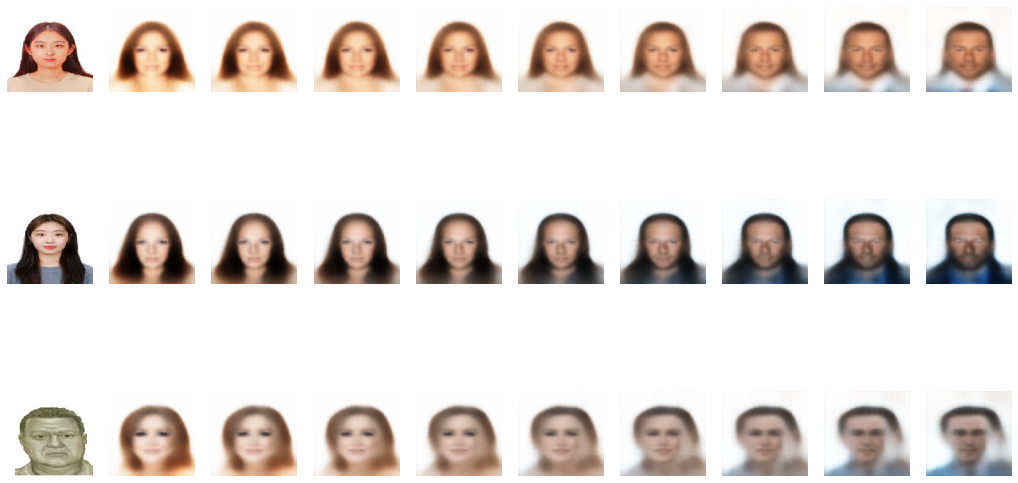

Blackhair Vector


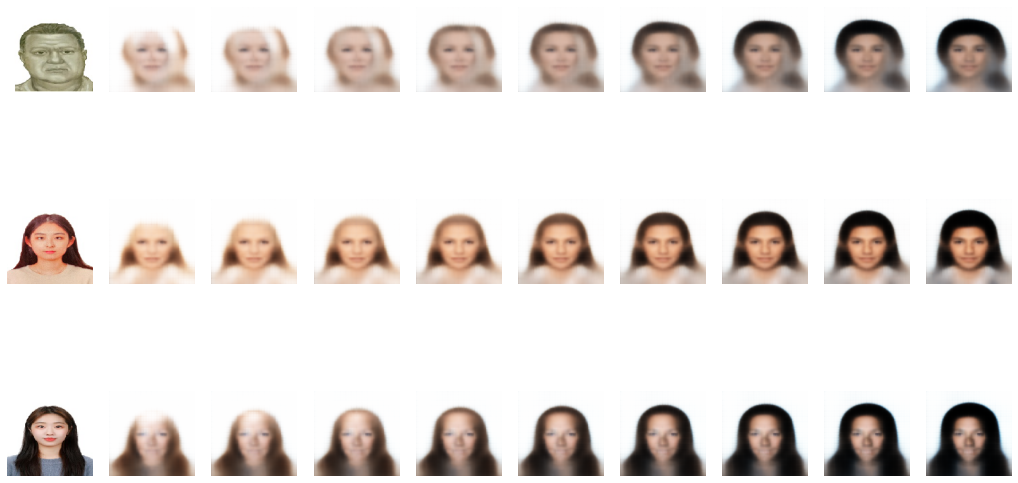

Blondehair Vector


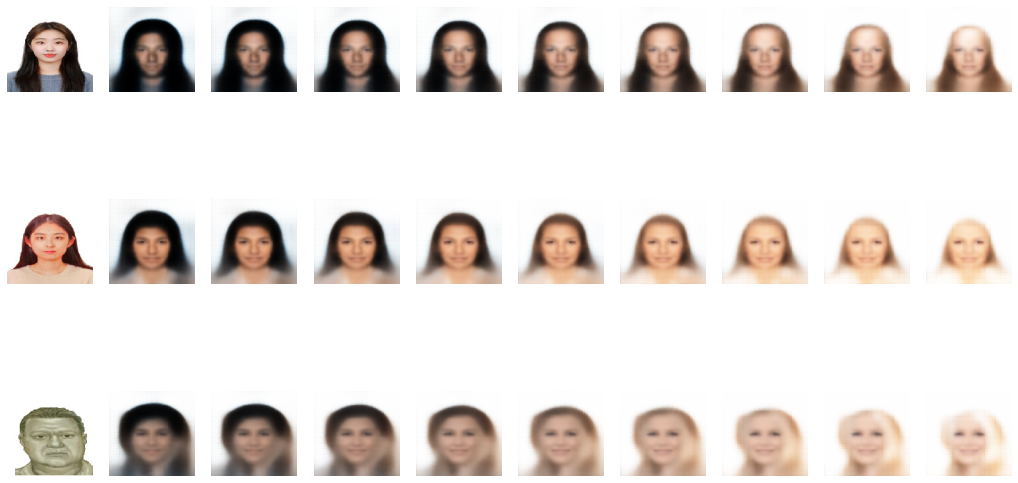

Brownhair Vector


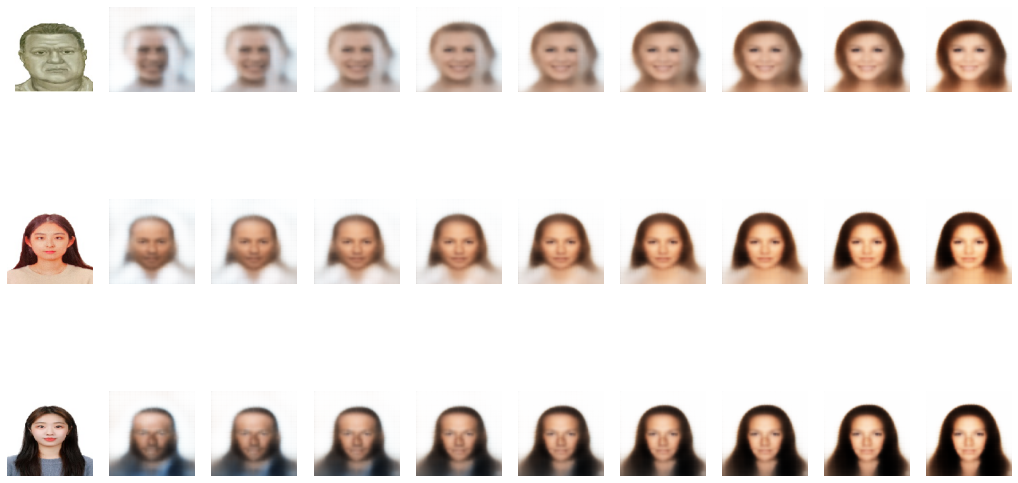

Grayhair Vector


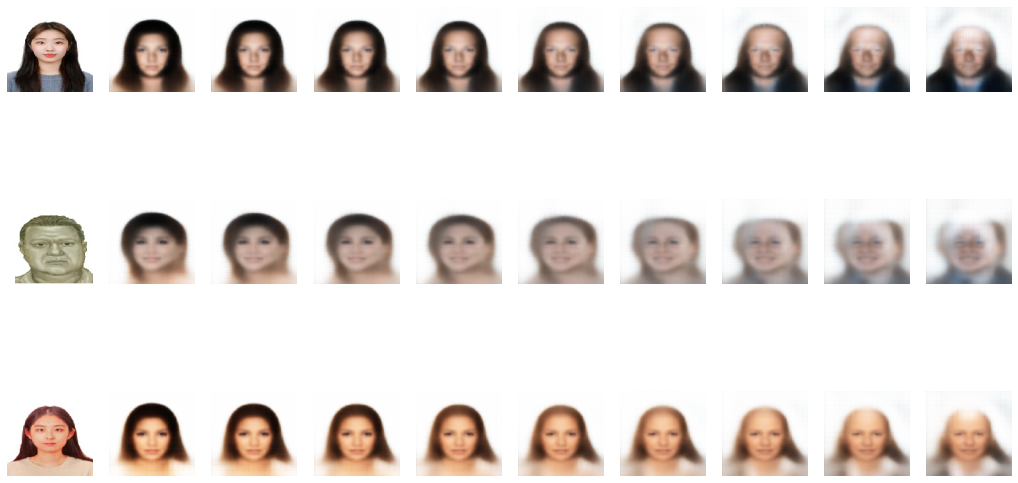

Straighthair Vector


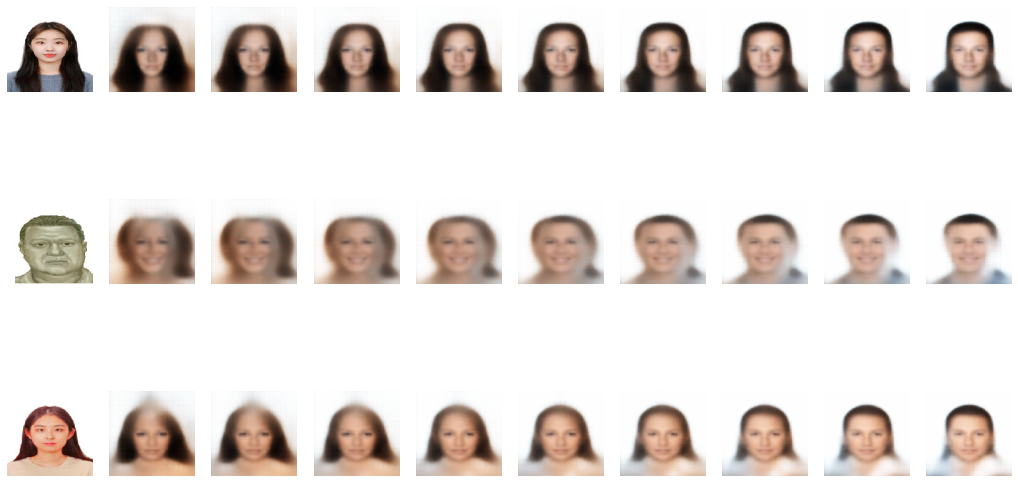

Wavy Vector


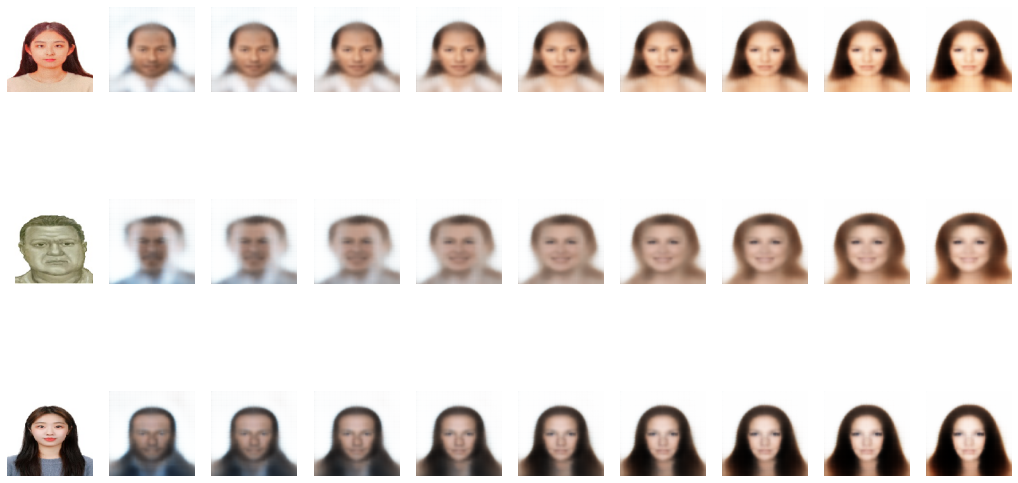

HeavyMakeUp Vector


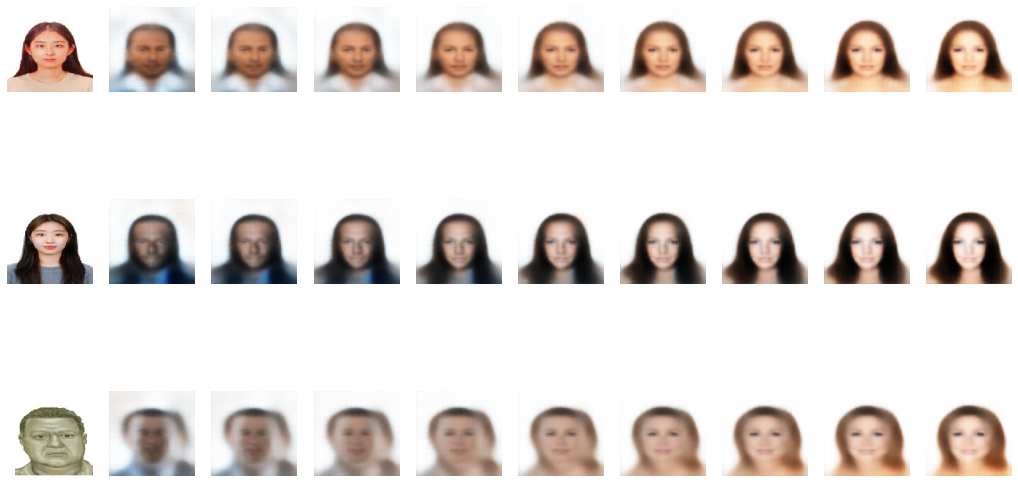

Mustache Vector


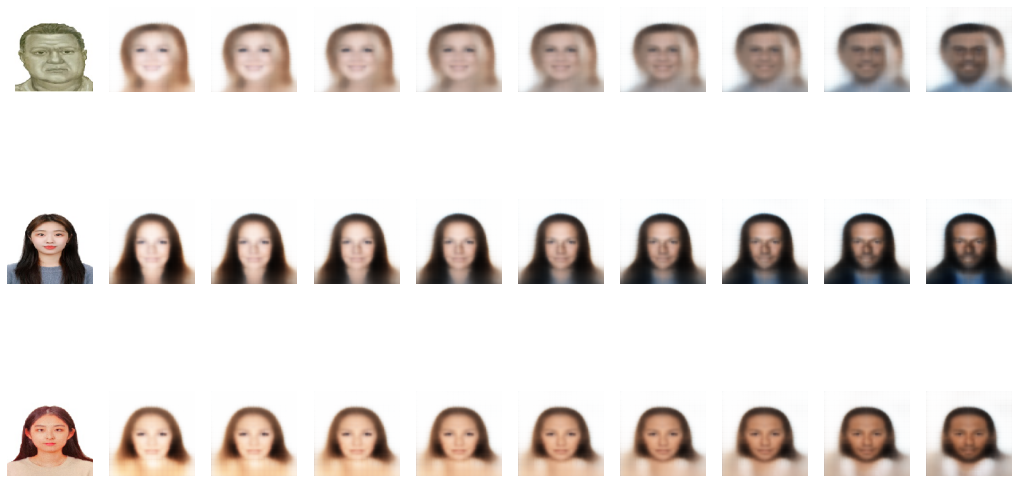

Hat Vector


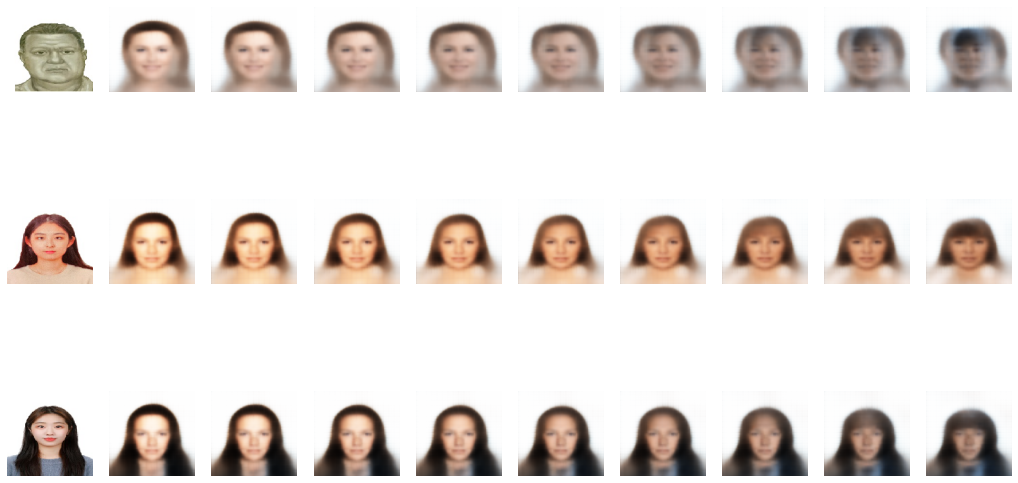

Eyeglasses Vector


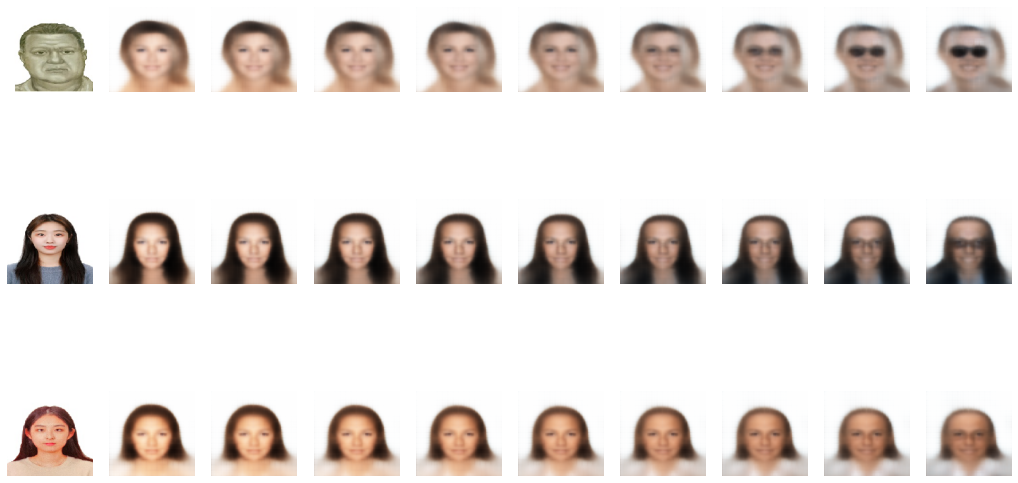

In [11]:
print('Male Vector')
add_vector_to_images(male_vec)

print('Blackhair Vector')
add_vector_to_images(black_hair_vec)

print('Blondehair Vector')
add_vector_to_images(blonde_hair_vec)

print('Brownhair Vector')
add_vector_to_images(brown_hair_vec)

print('Grayhair Vector')
add_vector_to_images(gray_hair_vec)

print('Straighthair Vector')
add_vector_to_images(straight_hair_vec)

print('Wavy Vector')
add_vector_to_images(wavy_hair_vec)

print('HeavyMakeUp Vector')
add_vector_to_images(heavy_makeup_vec)

print('Mustache Vector')
add_vector_to_images(mustache_vec)

print('Hat Vector')
add_vector_to_images(wearing_hat_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)